# 使用 LangGraph 和 LangSmith 构建多智能体 AI 系统

欢迎来到这个关于使用 LangGraph 构建**多智能体工作流**的综合指南！在这个笔记本中，我们将踏上从基础 ReAct 智能体到复杂多智能体客户支持系统的旅程。我们将探索核心 LangGraph 概念，利用其预构建库，并集成人机交互和长期记忆等高级功能。

## 什么是 LangGraph？

LangGraph 是一个专为构建有状态、多参与者应用程序而设计的库，支持 LLM、链和工具。它通过允许您更稳健地定义调用序列（链），包含循环、条件逻辑和管理复杂状态转换的能力，扩展了 LangChain。这使其非常适合创建需要多个`思考`和`行动`步骤的智能体工作流，或者需要不同专门智能体协作的场景。

## 为什么选择多智能体？

多智能体架构之所以强大，有以下几个原因：

*   **专业化和模块化**：多智能体系统由更小的专门智能体组成，而不是单一的整体智能体试图处理所有事情。每个智能体都针对特定任务或领域进行优化（例如，一个处理音乐查询，另一个处理发票详情）。这提高了其专业领域内的准确性和性能。
*   **灵活性和可扩展性**：可以通过简单地集成新的专门智能体来添加新功能，而无需重新训练或大幅修改现有智能体。智能体可以快速添加、移除或修改，使系统具有高度适应性。
*   **鲁棒性**：如果一个智能体在其特定任务中失败或表现不佳，它不一定会拖垮整个系统，因为其他智能体仍然可以正常运行。这有助于构建更具弹性的应用程序。
*   **复杂问题解决**：许多现实世界的问题需要不同类型的专业知识。多智能体系统可以模拟人类团队协作，将复杂查询分解为由最合适的专家智能体处理的子问题。

## 我们的客户支持场景

我们将模拟一个数字音乐商店的真实客户支持示例。智能体将与 [Chinook 数据库](https://www.sqlitetutorial.net/sqlite-sample-database/) 交互，该数据库包含有关客户、发票和音乐目录的综合信息。

我们的最终架构将如下所示：

![架构图](images/architecture.png) 

如您所见，系统从**客户验证**步骤（人机交互）开始，然后从长期记忆中**加载用户偏好**。**监督智能体**然后智能地将查询路由到适当的专门子智能体：**音乐目录子智能体**或**发票信息子智能体**。最后，系统在提供响应之前将任何新的用户偏好**保存**到长期记忆中。


要深入了解 LangGraph 原语和学习我们的框架，请查看我们的 [LangChain 学院](https://academy.langchain.com/courses/intro-to-langgraph)！


## 前期准备：环境设置

在我们开始构建多智能体系统之前，让我们先设置环境。这包括加载必要的环境变量、连接到示例数据库以及初始化内存存储。

#### 加载环境变量
首先，我们将从 `.env` 文件中加载我们的 API 密钥和其他配置。这可以将敏感信息与代码分开。在这个示例中，我们将使用 OpenAI 的模型，但 LangGraph 是模型无关的，因此您可以轻松地将 `ChatOpenAI` 替换为其他 `ChatModel` 提供商，例如 Azure OpenAI、Anthropic 或 Google Gemini。
请确保您的 `.env` 文件包含了 `.env.example` 文件中指定的所有密钥（例如，`OPENAI_API_KEY`）。


In [1]:
from dotenv import load_dotenv # 导入加载环境变量的函数
from langchain_openai import ChatOpenAI # 导入 OpenAI 聊天模型

# 从 .env 文件加载环境变量。`override=True` 参数
# 确保 .env 文件中的变量会覆盖现有的环境变量。
load_dotenv(dotenv_path=".env", override=True)

# 初始化 ChatOpenAI 模型。我们使用 Llama 3.3 系列的特定模型。
# 这个 `model` 对象将在整个笔记本中用于所有 LLM 交互。
llm = ChatOpenAI(model_name="meta-llama/Llama-3.3-70B-Instruct", temperature=0)

#### 加载示例客户数据（Chinook 数据库）
我们的客户支持代理将与数据库交互以检索信息。我们将使用 [Chinook 数据库](https://www.sqlitetutorial.net/sqlite-sample-database/)，这是一个流行的示例数据库，其中包含与客户信息、购买历史和音乐目录（艺术家、专辑、曲目、流派）相关的表。这为我们代理查询提供了一个丰富的数据集。
我们将在内存数据库中加载此 SQLite 数据库，以便在笔记本执行期间快速访问。这避免了持久性文件存储并简化了设置。


In [2]:
import sqlite3 # 用于 SQLite 数据库交互的标准 Python 库
import requests # 用于发送 HTTP 请求的库（下载 SQL 脚本）
from langchain_community.utilities.sql_database import SQLDatabase # LangChain 与 SQL 数据库交互的工具
from sqlalchemy import create_engine # SQLAlchemy 创建数据库引擎的函数
from sqlalchemy.pool import StaticPool # SQLAlchemy 用于内存数据库的连接池类

def get_engine_for_chinook_db():
    """获取 SQL 文件，填充内存数据库，并创建引擎。"""
    # Chinook 数据库原始 SQL 脚本的 URL
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    
    # 从 URL 获取 SQL 脚本内容
    response = requests.get(url)
    sql_script = response.text

    # 创建内存 SQLite 数据库连接。
    # `check_same_thread=False` 对于 SQLAlchemy 的 StaticPool 很重要。
    connection = sqlite3.connect(":memory:", check_same_thread=False)
    
    # 执行 SQL 脚本，用 Chinook 数据填充内存数据库
    connection.executescript(sql_script)
    
    # 为内存 SQLite 数据库创建 SQLAlchemy 引擎。
    # `creator=lambda: connection` 告诉 SQLAlchemy 如何获取新连接。
    # `poolclass=StaticPool` 用于内存数据库，确保重复使用相同的连接。
    # `connect_args` 直接传递给 `sqlite3.connect` 函数。
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

# 获取我们 Chinook 数据库的 SQLAlchemy 引擎
engine = get_engine_for_chinook_db()

# 从引擎创建 LangChain SQLDatabase 工具实例。
# 这个工具将帮助我们的智能体通过 SQL 查询与数据库交互。
db = SQLDatabase(engine)

#### 设置短期和长期内存

内存是构建智能体的关键组件。LangGraph 提供了管理工作流程中短期和长期内存的机制。

*   **短期内存（检查点器）**：这保存了特定对话线程的状态。它允许智能体在*单次对话*中保持上下文并从中断处继续。如果用户的查询需要多轮对话或涉及人工干预，检查点器确保图的状态被保存并可以恢复。
    *   我们使用 `MemorySaver` 进行内存中的短期内存存储，适合演示目的。在生产环境中，您通常会使用持久化检查点器（例如 SQL、Redis）。

*   **长期内存（InMemoryStore）**：这允许信息在*对话之间*或同一用户的不同会话中存储和调用。在我们的场景中，我们将使用它来存储用户偏好，实现个性化。例如，如果用户提到他们最喜欢的音乐流派，这些信息可以被存储并在未来的交互中使用。
    *   我们使用 `InMemoryStore` 进行内存中的长期存储。与检查点器类似，在生产环境中会使用持久化存储（例如向量数据库、键值存储）。

In [3]:
from langgraph.checkpoint.memory import MemorySaver # 用于短期内存（线程级状态持久化）
from langgraph.store.memory import InMemoryStore # 用于长期内存（存储用户偏好）

# 初始化用于长期内存的 `InMemoryStore`。
# 这个存储将保存跨会话的用户特定数据，如音乐偏好。
in_memory_store = InMemoryStore()

# 初始化用于短期（线程级）内存的 `MemorySaver`。
# 这个检查点器在每一步后保存图的状态，允许在线程内重启或中断。
checkpointer = MemorySaver()

## 第一部分：构建 ReAct 子智能体

我们的多智能体系统将由专门的子智能体组成。我们将从构建两个基础的 ReAct 智能体开始，一个从头开始构建以了解核心组件，另一个使用 LangGraph 的预构建工具进行快速开发。

### 1.1 从头构建 ReAct 智能体：音乐目录子智能体

我们的第一个子智能体将专门处理与音乐商店目录相关的客户查询。这个智能体将利用一组工具从 Chinook 数据库中获取有关艺术家、专辑、曲目和流派的信息。

ReAct（推理和行动）框架是构建智能体的流行模式，它将推理步骤与行动步骤（工具使用）交替进行。智能体`推理`使用什么工具，然后通过调用该工具进行`行动`，接着`观察`结果再次进行`推理`。

![音乐子智能体架构](images/music_subagent.png)

#### 状态

在 LangGraph 中，**状态**是一个关键概念。它充当智能体的共享内存，是在图的节点之间传递的数据结构。每个节点接收当前状态，执行其逻辑，并返回状态更新，然后成为下一个节点的输入。通过状态的这种连续信息流允许图保持上下文并在进展过程中积累信息。

对于我们的客户支持智能体，状态将跟踪以下关键元素：

1.  `customer_id`：表示与智能体交互的客户 ID 的字符串。这对于个性化查询（例如检查发票历史）至关重要。
2.  `messages`：`AnyMessage` 对象的注释列表。这形成了对话历史，包括用户输入、智能体响应和工具输出。`add_messages` 确保新消息被追加到列表中，保持对话流程。
3.  `loaded_memory`：一个字符串，将保存从长期内存存储中加载的任何用户偏好或相关信息。这允许智能体根据过去的交互定制响应。
4.  `remaining_steps`：一个 `RemainingSteps` 对象。这是 LangGraph 管理状态的一部分，有助于跟踪在达到递归限制之前剩余的步数，防止循环图中的无限循环。

In [4]:
from typing_extensions import TypedDict # 用于定义带有类型提示的字典
from typing import Annotated, List # 用于列表类型提示和添加注释
from langgraph.graph.message import AnyMessage, add_messages # 用于管理图状态中的消息
from langgraph.managed.is_last_step import RemainingSteps # 用于跟踪递归限制

class State(TypedDict):
    """表示我们 LangGraph 智能体的状态。"""
    # customer_id: 存储当前客户的唯一标识符。
    customer_id: str
    
    # messages: 形成对话历史的消息列表。
    # 使用 `add_messages` 注释确保新消息被追加而不是覆盖。
    messages: Annotated[list[AnyMessage], add_messages]
    
    # loaded_memory: 存储从长期内存存储中加载的信息，
    # 通常是用户偏好或历史上下文。
    loaded_memory: str
    
    # remaining_steps: 由 LangGraph 用于跟踪允许的步数
    # 以防止循环图中的无限循环。
    remaining_steps: RemainingSteps 

#### Tools

工具是指 LLM（大型语言模型）可以调用的外部功能，用于扩展其纯文本生成之外的Capabilities（能力）。这些工具可以是API、数据库查询，或是任何任意的Python函数。在我们的音乐目录子代理中，我们将定义一组工具，这些工具与Chinook数据库交互，以获取与音乐相关的信息。

我们使用LangChain库中的`@tool`装饰器，可以轻松地将Python函数暴露为LLM能够学习使用的工具。该装饰器会自动生成一个LLM能够理解的Schema（模式），这使得LLM能够判断何时以及如何调用该工具。


In [ ]:
from langchain_core.tools import tool # 用于将函数定义为 LangChain 工具的装饰器
import ast # 用于安全评估包含 Python 字面结构的字符串的模块

@tool
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # 执行SQL查询以检索专辑标题和艺术家名称
    # 从Album和Artist表中获取数据，通过艺术家ID关联并按艺术家名称过滤
    # `db.run` 是LangChain的SQLDatabase中用于执行查询的实用工具
    # `include_columns=True` 确保结果中包含列名以提高可读性
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # 执行SQL查询以查找指定艺术家（或相似艺术家）的曲目
    # 关联Album、Artist和Track表以获取歌曲名称和艺术家名称
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    从数据库中获取匹配特定流派的歌曲。
    
    参数:
        genre (str): 要获取的歌曲的流派。
    
    返回:
        list[dict]: 匹配指定流派的歌曲列表。
    """
    # 首先，查找给定流派名称的GenreId
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # 如果未找到流派ID，返回提示信息
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # 安全地评估db.run返回的字符串结果以获取元组列表
    genre_ids = ast.literal_eval(genre_ids)
    # 提取GenreId值并将其连接成逗号分隔的字符串用于IN子句
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # 构造查询以获取找到的流派ID对应的歌曲
    # 关联Track、Album和Artist表，并将结果限制为8条
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # 如果未找到该流派的歌曲，返回提示信息
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # 安全地评估字符串结果并将其格式化为字典列表
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # 执行SQL查询以通过歌曲标题检查歌曲是否存在
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# 将所有与音乐相关的工具聚合到一个列表中。
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# 将工具绑定到我们的 ChatOpenAI 模型。
# 此步骤配置 LLM，使其了解可用工具及其模式，
# 从而允许它在用户查询适当时生成工具调用。
llm_with_music_tools = llm.bind_tools(music_tools)

In [ ]:
from langchain_core.tools import tool # 用于将函数定义为 LangChain 工具的装饰器
import ast # 用于安全地评估包含Python字面结构的字符串

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # 执行SQL查询以检索专辑标题和艺术家名称
    # 从Album和Artist表中获取数据，通过艺术家名称进行连接和过滤
    # `db.run`是LangChain的SQLDatabase中用于执行查询的实用工具
    # `include_columns=True`确保结果中包含列名以提高可读性
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # 执行SQL查询以查找指定艺术家（或相似艺术家）的曲目（歌曲）
    # 连接Album、Artist和Track表以获取歌曲名称和艺术家名称
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    # 首先，查找给定流派名称的GenreId
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # 如果未找到流派ID，返回提示信息
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # 安全地评估db.run返回的字符串结果以获取元组列表
    genre_ids = ast.literal_eval(genre_ids)
    # 提取GenreId值并将其连接成逗号分隔的字符串，用于IN子句
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # 构造查询以获取找到的流派ID的歌曲
    # 连接Track、Album和Artist表，并将结果限制为8条
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # 如果未找到该流派的歌曲，返回提示信息
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # 安全地评估字符串结果并将其格式化为字典列表
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # 执行SQL查询以通过标题检查歌曲是否存在
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# 将所有与音乐相关的工具聚合到一个列表中
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# 将工具绑定到我们的ChatOpenAI模型
# 此步骤配置LLM，使其了解可用的工具及其架构，
# 从而能够根据用户的查询适当地生成工具调用
llm_with_music_tools = llm.bind_tools(music_tools)

In [ ]:
from langchain_core.tools import tool # 用于将函数定义为 LangChain 工具的装饰器
import ast # 用于安全地评估包含 Python 字面结构的字符串

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # 执行 SQL 查询以从 Album 和 Artist 表中检索专辑标题和艺术家名称
    # 通过连接表并按艺术家名称过滤
    # `db.run` 是 LangChain 的 SQLDatabase 中用于执行查询的实用工具
    # `include_columns=True` 确保结果中包含列名以提高可读性
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # 执行 SQL 查询以查找给定艺术家或相似艺术家的曲目（歌曲）
    # 连接 Album、Artist 和 Track 表以获取歌曲名称和艺术家名称
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    # 首先，查找给定流派名称的 GenreId
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # 如果未找到流派 ID，则返回信息提示
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # 安全地评估 db.run 的字符串结果以获取元组列表
    genre_ids = ast.literal_eval(genre_ids)
    # 提取 GenreId 值并将它们连接成逗号分隔的字符串用于 IN 子句
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # 构造查询以获取找到的流派 ID 的歌曲
    # 连接 Track、Album 和 Artist 表，并将结果限制为 8 个
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # 如果未找到该流派的歌曲，则返回信息提示
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # 安全地评估字符串结果并将其格式化为字典列表
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # 执行 SQL 查询以通过标题检查歌曲是否存在
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# 将所有与音乐相关的工具聚合到一个列表中。
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# 将工具绑定到我们的 ChatOpenAI 模型。
# 此步骤配置 LLM，使其了解可用工具及其模式，
# 从而允许它在用户查询适当时生成工具调用。
llm_with_music_tools = llm.bind_tools(music_tools)

In [ ]:
from langchain_core.tools import tool # 用于将函数定义为 LangChain 工具的装饰器
import ast # Module to safely evaluate strings containing Python literal structures

@tool
@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # 执行SQL查询以从Album和Artist表中检索专辑标题和艺术家名称
    # 通过连接表并按艺术家名称过滤
    # `db.run` 是LangChain的SQLDatabase中用于执行查询的实用工具
    # `include_columns=True` 确保结果中包含列名以提高可读性
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # 执行SQL查询以查找指定艺术家（或相似艺术家）的曲目（歌曲）
    # 连接Album、Artist和Track表以获取歌曲名称和艺术家名称
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    # 首先，查找给定流派名称的GenreId
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # 如果未找到流派ID，返回提示信息
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # 安全地评估db.run的字符串结果以获取元组列表
    genre_ids = ast.literal_eval(genre_ids)
    # 提取GenreId值并将它们连接成逗号分隔的字符串用于IN子句
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # 构造查询以获取找到的流派ID的歌曲
    # 连接Track、Album和Artist表，并将结果限制为8个
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # 如果未找到该流派的歌曲，返回提示信息
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # 安全地评估字符串结果并将其格式化为字典列表
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # 执行SQL查询以通过标题检查歌曲是否存在
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# 将所有与音乐相关的工具聚合到一个列表中。
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# 将工具绑定到我们的 ChatOpenAI 模型。
# 此步骤配置 LLM，使其了解可用工具及其模式，
# 从而允许它在用户查询适当时生成工具调用。
llm_with_music_tools = llm.bind_tools(music_tools)

In [ ]:
from langchain_core.tools import tool # 用于将函数定义为 LangChain 工具的装饰器
import ast # 用于安全地评估包含 Python 字面结构的字符串

@tool
def get_albums_by_artist(artist: str):
    """Get albums by an artist."""
    # 执行 SQL 查询以从 Album 和 Artist 表中检索专辑标题和艺术家名称
    # 通过连接表并按艺术家名称过滤
    # `db.run` 是 LangChain 的 SQLDatabase 中用于执行查询的实用工具
    # `include_columns=True` 确保结果中包含列名以提高可读性
    return db.run(
        f"""
        SELECT Album.Title, Artist.Name 
        FROM Album 
        JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_tracks_by_artist(artist: str):
    """Get songs by an artist (or similar artists)."""
    # 执行 SQL 查询以查找给定艺术家或相似艺术家的曲目（歌曲）
    # 连接 Album、Artist 和 Track 表以获取歌曲名称和艺术家名称
    return db.run(
        f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName 
        FROM Album 
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId 
        LEFT JOIN Track ON Track.AlbumId = Album.AlbumId 
        WHERE Artist.Name LIKE '%{artist}%';
        """,
        include_columns=True
    )

@tool
def get_songs_by_genre(genre: str):
    """
    Fetch songs from the database that match a specific genre.
    
    Args:
        genre (str): The genre of the songs to fetch.
    
    Returns:
        list[dict]: A list of songs that match the specified genre.
    """
    # 首先，查找给定流派名称的 GenreId
    genre_id_query = f"SELECT GenreId FROM Genre WHERE Name LIKE '%{genre}%'"
    genre_ids = db.run(genre_id_query)
    
    # 如果未找到流派 ID，则返回信息提示
    if not genre_ids:
        return f"No songs found for the genre: {genre}"
    
    # 安全地评估 db.run 的字符串结果以获取元组列表
    genre_ids = ast.literal_eval(genre_ids)
    # 提取 GenreId 值并将它们连接成逗号分隔的字符串用于 IN 子句
    genre_id_list = ", ".join(str(gid[0]) for gid in genre_ids)

    # 构造查询以获取找到的流派 ID 的歌曲
    # 连接 Track、Album 和 Artist 表，并将结果限制为 8 个
    songs_query = f"""
        SELECT Track.Name as SongName, Artist.Name as ArtistName
        FROM Track
        LEFT JOIN Album ON Track.AlbumId = Album.AlbumId
        LEFT JOIN Artist ON Album.ArtistId = Artist.ArtistId
        WHERE Track.GenreId IN ({genre_id_list})
        GROUP BY Artist.Name
        LIMIT 8;
    """
    songs = db.run(songs_query, include_columns=True)
    
    # 如果未找到该流派的歌曲，则返回信息提示
    if not songs:
        return f"No songs found for the genre: {genre}"
        
    # 安全地评估字符串结果并将其格式化为字典列表
    formatted_songs = ast.literal_eval(songs)
    return [
        {"Song": song["SongName"], "Artist": song["ArtistName"]}
        for song in formatted_songs
    ]

@tool
def check_for_songs(song_title):
    """Check if a song exists by its name."""
    # 执行 SQL 查询以通过标题检查歌曲是否存在
    return db.run(
        f"""
        SELECT * FROM Track WHERE Name LIKE '%{song_title}%';
        """,
        include_columns=True
    )

# 将所有与音乐相关的工具聚合到一个列表中。
music_tools = [get_albums_by_artist, get_tracks_by_artist, get_songs_by_genre, check_for_songs]

# 将工具绑定到我们的 ChatOpenAI 模型。
# 此步骤配置 LLM，使其了解可用工具及其模式，
# 从而允许它在用户查询适当时生成工具调用。
llm_with_music_tools = llm.bind_tools(music_tools)

#### Nodes

在LangGraph中，**节点（Nodes）** 是您图（Graph）的基本构建模块。它们本质上是一些Python函数（或JS/TS函数），这些函数接收图的`State`（状态）作为输入，执行某些逻辑（例如，调用LLM、调用工具、更新数据），然后返回对`State`的更新。

对于我们的ReAct代理，我们将定义两种主要的节点类型：

1.  **`music_assistant`（推理节点）**：这个节点是一个负责`推理`的LLM。它接收当前的对话历史和用户查询，考虑可用的工具，并决定下一步的最佳行动。这可能是调用某个工具，或者如果查询已经得到满足，则生成最终回复。

2.  **`music_tool_node`（执行节点）**：这个节点负责`执行`。当`music_assistant`决定使用某个工具时，`music_tool_node`会接收工具调用，执行指定的工具函数，然后将工具的输出返回给图的状态。LangGraph提供了一个方便的`ToolNode`工具类，可以自动处理工具的执行。


In [ ]:
from langgraph.prebuilt import ToolNode # 用于执行工具的预构建节点

# 创建一个ToolNode实例。这个节点会自动执行由绑定了这些工具的LLM生成的任何工具调用。
music_tool_node = ToolNode(music_tools)

In [ ]:
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage # 用于对话历史的消息类型
from langchain_core.runnables import RunnableConfig # 用于传递给可运行对象的配置参数

# 为音乐助手定义系统提示
# 此提示为LLM提供指令和角色定位
# 强调了代理的角色、核心职责和搜索指南
# `memory`占位符允许我们注入来自长期记忆的用户偏好
def generate_music_assistant_prompt(memory: str = "None") -> str:
    return f"""
    You are a member of the assistant team, your role specifically is to focused on helping customers discover and learn about music in our digital catalog. 
    If you are unable to find playlists, songs, or albums associated with an artist, it is okay. 
    Just inform the customer that the catalog does not have any playlists, songs, or albums associated with that artist.
    You also have context on any saved user preferences, helping you to tailor your response. 
    
    CORE RESPONSIBILITIES:
    - Search and provide accurate information about songs, albums, artists, and playlists
    - Offer relevant recommendations based on customer interests
    - Handle music-related queries with attention to detail
    - Help customers discover new music they might enjoy
    - You are routed only when there are questions related to music catalog; ignore other questions. 
    
    SEARCH GUIDELINES:
    1. Always perform thorough searches before concluding something is unavailable
    2. If exact matches aren't found, try:
       - Checking for alternative spellings
       - Looking for similar artist names
       - Searching by partial matches
       - Checking different versions/remixes
    3. When providing song lists:
       - Include the artist name with each song
       - Mention the album when relevant
       - Note if it's part of any playlists
       - Indicate if there are multiple versions
    
    Additional context is provided below: 

    Prior saved user preferences: {memory}
    
    Message history is also attached.  
    """

# 定义音乐助手节点函数
# 此函数接收当前的`State`和`RunnableConfig`
def music_assistant(state: State, config: RunnableConfig): 

    # 从状态中获取长期记忆（用户偏好）
    # 如果状态中不存在'loaded_memory'，则默认为"None"
    memory = "None" 
    if "loaded_memory" in state: 
        memory = state["loaded_memory"]

    # 生成音乐助手的系统提示，注入加载的记忆
    music_assistant_prompt = generate_music_assistant_prompt(memory)

    # 使用系统提示和当前消息历史调用LLM（llm_with_music_tools）
    # LLM将决定是调用工具还是生成最终响应
    response = llm_with_music_tools.invoke([SystemMessage(music_assistant_prompt)] + state["messages"])
    
    # 通过将LLM的响应附加到'messages'列表来更新状态
    # State中的'add_messages'注解确保正确附加
    return {"messages": [response]}

#### Edges

**边（Edges）** 是LangGraph图中节点之间的连接。它们定义了应用程序内部的执行流程和顺序。
*   **普通边（Normal Edges）**：这些边是确定性的，意味着它们总是从一个指定的节点直接连接到另一个指定的节点。例如，`graph.add_edge("node_A", "node_B")` 表示在 `node_A` 完成后，`node_B` 将始终作为下一个执行的节点。
*   **条件边（Conditional Edges）**：这些边提供了动态路由的能力。与固定目标不同，条件边使用一个函数（称为“路由器”或“条件函数”），该函数检查当前的 `State` 并返回一个字符串，对应于下一个要访问的节点的名称。这允许对工作流的路径进行灵活、智能的决策。
对于我们的ReAct代理，我们需要在 `music_assistant` 节点之后添加一个 **条件边**。这条边将决定：
- 如果 `music_assistant` 决定调用工具，我们应该路由到 `music_tool_node` 来执行它。
- 如果 `music_assistant` 生成了一条最终的、可供人类阅读的回复（即没有调用工具），我们应该结束子代理的执行，因为查询已经解决。
`should_continue` 函数实现了这个条件逻辑。


In [ ]:
# 定义一个名为`should_continue`的条件边缘函数
# 此函数根据LLM的响应确定图中的下一步
def should_continue(state: State, config: RunnableConfig):
    # 从当前状态获取消息列表
    messages = state["messages"]
    # 获取最后一条消息，这是来自`music_assistant` LLM的响应
    last_message = messages[-1]
    
    # 检查最后一条消息是否包含任何工具调用
    # 当LLM决定使用函数时会生成`tool_calls`
    if not last_message.tool_calls:
        # 如果没有工具调用，说明LLM已生成最终答案
        # 在这种情况下，子代理的工作已完成，所以我们返回"end"来表示完成
        return "end"
    # 否则，如果有工具调用
    else:
        # 我们需要执行工具，所以我们返回"continue"以路由到工具执行节点
        return "continue"

#### Compile Graph!


现在我们已经定义了 `State`（数据如何流动）、`Nodes`（执行什么操作）和 `Edges`（控制如何流动），我们就可以将它们组装成一个完整的LangGraph工作流。这个过程称为 **编译**。
`StateGraph` 类用于定义我们代理的结构。我们添加节点和边，然后 `compile`（编译）这个图。编译将定义好的图转换为一个可运行的对象，准备被调用。
使用的关键方法：
*   `StateGraph(State)`：使用我们定义的状态模式初始化一个图。
*   `add_node(name, node_function)`：向图中添加一个节点，将一个名称与一个可调用的Python函数关联起来。
*   `add_edge(source, target)`：从 `source` 节点到 `target` 节点创建一个直接的、无条件的边。
*   `add_conditional_edges(source, condition_function, mapping)`：创建一个动态边。`condition_function` 会被调用，根据其返回值来决定下一个节点，该返回值必须匹配 `mapping` 字典中的一个键。
    *   `START`：一个特殊的入口点，表示图执行的开始。
    *   `END`：一个特殊的出口点，表示图执行的完成。
*   `compile(name, checkpointer, store)`：完成图的编译。
    *   `name`：编译后图的唯一标识符。
    *   `checkpointer`：短期记忆机制（例如 `MemorySaver`），用于持久化和恢复图的状态。
    *   `store`：长期记忆机制（例如 `InMemoryStore`），用于跨会话持久化数据。


USER_AGENT environment variable not set, consider setting it to identify your requests.


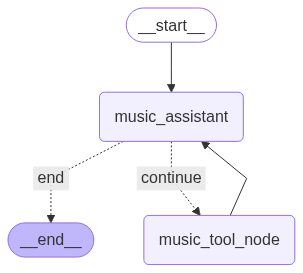

In [ ]:
from langgraph.graph import StateGraph, START, END # LangGraph核心类和特殊节点名称
from utils import show_graph # 用于可视化图的工具函数（假设在utils.py文件中）

# 使用我们定义的`State`模式初始化StateGraph
# 这告诉LangGraph如何在图中流转和管理数据
music_workflow = StateGraph(State)

# 向图中添加'music_assistant'节点
# 该节点负责LLM的推理和生成工具调用或最终响应
music_workflow.add_node("music_assistant", music_assistant)

# 向图中添加'music_tool_node'节点
# 该节点负责在LLM请求时执行工具
music_workflow.add_node("music_tool_node", music_tool_node)


# 定义图的起始点
# 所有查询最初都将进入'music_assistant'节点
music_workflow.add_edge(START, "music_assistant")

# 从'music_assistant'添加条件边
# 将调用`should_continue`函数来确定下一个节点
music_workflow.add_conditional_edges(
    "music_assistant", # 源节点
    should_continue,   # 要调用的条件函数
    {
        # 如果`should_continue`返回"continue"，路由到`music_tool_node`
        "continue": "music_tool_node",
        # 如果`should_continue`返回"end"，终止图执行
        "end": END,
    },
)

# 从'music_tool_node'添加一条普通边返回到'music_assistant'
# 工具执行完成后，结果会反馈给LLM进行进一步推理或生成最终响应(ReAct循环)
music_workflow.add_edge("music_tool_node", "music_assistant")

# 将图编译为可运行对象
# `name`: 此编译图的唯一标识符(用于调试和日志记录)
# `checkpointer`: 线程特定状态的短期记忆机制(MemorySaver)
# `store`: 持久化用户数据的长期记忆机制(InMemoryStore)
music_catalog_subagent = music_workflow.compile(name="music_catalog_subagent", checkpointer=checkpointer, store = in_memory_store)

# 显示编译后图的可视化结果
show_graph(music_catalog_subagent)

#### 测试音乐目录子代理
现在我们的第一个ReAct子代理已经编译完成，让我们来测试它的功能。我们将模拟一个客户咨询，并观察代理如何处理它，包括可能调用工具并提供回复。
测试中的关键元素：
*   `uuid.uuid4()`：为每次对话生成一个唯一的线程ID。这对于检查点机制（checkpointer）来为不同的对话维护各自的状态至关重要。
    *   在实际应用中，这个 `thread_id` 通常会对应一个用户会话或一个唯一的对话标识符。
*   `config`：传递给 `invoke` 方法的字典，包含可配置的参数，例如 `thread_id`。检查点机制使用这个 `thread_id` 来加载和保存正确的状态。
*   `invoke()`：启动LangGraph的执行。它接收初始输入（在我们的 `State` 中是 `messages`）和 `config`。
*   `pretty_print()`：一个实用方法（假设它为 `AnyMessage` 或类似类型定义了），用于以可读的格式显示消息，展示角色和内容。


In [ ]:
import uuid # 用于生成唯一标识符的模块

# 为此对话生成唯一的线程ID
# 这确保对话状态是隔离的，并且可以稍后恢复
thread_id = uuid.uuid4()

# 定义客户的问题
question = "I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?"

# 创建用于调用图的配置字典
# thread_id对于检查点管理状态是必需的
config = {"configurable": {"thread_id": thread_id}}

# 使用初始人类消息和配置调用music_catalog_subagent
# invoke方法运行图直到完成并返回最终状态
result = music_catalog_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 遍历最终状态中的消息并打印它们以供观察
# pretty_print()提供消息内容和角色的格式化输出
for message in result["messages"]:
   message.pretty_print()

================================ Human Message =================================

I like the Rolling Stones. What songs do you recommend by them or by other artists that I might like?
================================== Ai Message ==================================
Tool Calls:
  get_tracks_by_artist (chatcmpl-tool-f4507d6d0d674033bea8c65d87db6a3e)
 Call ID: chatcmpl-tool-f4507d6d0d674033bea8c65d87db6a3e
  Args:
    artist: The Rolling Stones
================================= Tool Message =================================
Name: get_tracks_by_artist

[{'SongName': 'Time Is On My Side', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Heart Of Stone', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Play With Fire', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Satisfaction', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'As Tears Go By', 'ArtistName': 'The Rolling Stones'}, {'SongName': 'Get Off Of My Cloud', 'ArtistName': 'The Rolling Stones'}, {'SongName': "Mother's Little 

### 1.2. 使用LangGraph预构建功能构建ReAct代理：发票信息子代理
虽然从头构建代理有助于深入理解，但LangGraph也提供了**预构建的库**，用于常见的架构模式。这些预构建的解决方案允许快速开发标准代理模式（如ReAct），从而节省大量样板代码。
您可以在这里找到所有可用的预构建库列表：[LangGraph预构建库](https://langchain-ai.github.io/langgraph/prebuilt/#available-libraries)
在本节中，我们将演示如何使用`create_react_agent`这个预构建的实用工具来创建我们的第二个子代理，即**发票信息子代理**。该代理将负责处理所有与发票和过往购买记录相关的客户咨询。
![发票子代理架构](images/invoice_subagent.png)



#### 定义发票子代理的工具和提示
与我们的音乐子代理类似，发票子代理也需要自己的一套专用工具和定制的提示。这些工具将与Chinook数据库交互，以检索发票相关的信息。

每个工具都旨在回答客户可能对其发票提出的特定类型查询。提示将指导大语言模型（LLM）理解其角色并有效使用这些工具。


In [ ]:
from langchain_core.tools import tool # 再次导入tool装饰器

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    # 执行SQL查询以获取指定客户ID的所有发票详情，
    # 按发票日期降序排序（最新的排在前面）
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    # 执行SQL查询以获取发票详情及其中商品的单价，
    # 根据指定的客户ID，按单价降序排序（最高价格排在前面）
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    # 执行SQL查询并返回结果
    return db.run(query)

@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    # 执行SQL查询以查找与特定发票和客户相关联的员工信息
    # 通过连接Employee、Customer和Invoice表来获取员工的名字、职位和邮箱
    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    # 检查是否找到任何员工信息
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info

# 将所有与发票相关的工具聚合到一个列表中
invoice_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer]

In [ ]:
# 定义发票信息子代理的系统提示
# 此提示设置了LLM在此子代理域中的角色和核心职责
# 明确列出了此代理可用的工具并提供了使用指南
invoice_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized for retrieving and processing invoice information. You are routed for invoice-related portion of the questions, so only respond to them.. 

    You have access to three tools. These tools enable you to retrieve and process invoice information from the database. Here are the tools:
    - get_invoices_by_customer_sorted_by_date: This tool retrieves all invoices for a customer, sorted by invoice date.
    - get_invoices_sorted_by_unit_price: This tool retrieves all invoices for a customer, sorted by unit price.
    - get_employee_by_invoice_and_customer: This tool retrieves the employee information associated with an invoice and a customer.
    
    If you are unable to retrieve the invoice information, inform the customer you are unable to retrieve the information, and ask if they would like to search for something else.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information about invoices, including customer details, invoice dates, total amounts, employees associated with the invoice, etc. when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional context that you should use to help answer the customer's query. It will be provided to you below:
    """

#### 使用预构建库：`create_react_agent`
现在，让我们使用LangGraph的`create_react_agent`函数来组装我们的发票子代理。这个实用工具抽象了标准ReAct循环的节点和边定义，使我们能够快速创建一个可运行的代理。
`create_react_agent`函数处理以下内容：
*   将提供的`tools`绑定到`model`。
*   将大语言模型（`model`）设置为推理节点。
*   设置一个`ToolNode`来执行工具。
*   定义条件逻辑（边），以在LLM和工具之间循环，直到生成最终答案或达到递归限制。
我们向它提供以下参数：
*   `model`：要使用的大语言模型（我们的`ChatOpenAI`实例）。
*   `tools`：代理可用的函数列表。
*   `name`：此代理的唯一名称（在多代理系统中用于标识）。
*   `prompt`：指导LLM行为的系统提示。
*   `state_schema`：我们定义的`State`类，确保代理之间的一致性。
*   `checkpointer`和`store`：我们的内存机制，用于线程级状态和长期用户数据。


In [ ]:
from langgraph.prebuilt import create_react_agent # 导入预构建的 ReAct agent 创建器

# 使用预构建的 `create_react_agent` 定义发票信息子代理
# 此函数在内部为 ReAct 循环设置节点（LLM 和 ToolNode）和边
invoice_information_subagent = create_react_agent(
    llm,                          # 用于推理的语言模型
    tools=invoice_tools,            # 此代理可用的工具列表
    name="invoice_information_subagent", # 图中此代理的唯一名称
    prompt=invoice_subagent_prompt, # 此代理的系统提示，包含其角色和指令
    state_schema=State,             # 图的共享状态模式
    checkpointer=checkpointer,      # 用于短期（线程级）内存的检查点
    store = in_memory_store         # 用于长期用户数据的内存存储
)

#### 测试发票信息子代理！
让我们测试我们新创建的发票信息子代理，以确保它能正确处理与发票相关的查询并使用其特定的工具。


In [ ]:
thread_id = uuid.uuid4() # 为此测试对话生成新的唯一线程ID

# 为发票子代理定义示例问题
question = "My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?"

# 使用线程ID设置配置
config = {"configurable": {"thread_id": thread_id}}

# 使用问题和配置调用发票子代理
result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 打印结果中的对话历史记录以进行验证
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_subagent
Tool Calls:
  get_invoices_by_customer_sorted_by_date (chatcmpl-tool-1755f3fbbda643d39521f80524ece99d)
 Call ID: chatcmpl-tool-1755f3fbbda643d39521f80524ece99d
  Args:
    customer_id: 1
================================= Tool Message =================================
Name: get_invoices_by_customer_sorted_by_date

[(382, 1, '2025-08-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 8.91), (327, 1, '2024-12-07 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 13.86), (316, 1, '2024-10-27 00:00:00', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', 1.98), (195

## 第二部分：构建多代理架构（监督代理）
现在，我们已经有了两个专门的子代理——一个用于音乐目录咨询，另一个用于发票信息——下一步合乎逻辑的就是确保客户查询能够被路由到相应的代理。这时，**监督代理**就发挥作用了。
监督代理充当中央协调者的角色，监督工作流程，并根据客户的查询智能地调用最相关的子代理。这消除了每个子代理都需要理解所有可能查询类型的需要，使它们能够专注于自己的核心专长。
### 监督代理的角色
![监督代理架构](images/supervisor.png)
监督代理的主要职责包括：
*   **意图识别**：分析传入的客户查询，以确定其主要意图（例如，与音乐相关、与发票相关，或其他）。
    *   `music_catalog_information_subagent`：处理关于歌曲、专辑、艺术家、流派和音乐偏好的查询。
    *   `invoice_information_subagent`：处理关于过往购买、发票和账单详情的查询。
*   **路由**：根据识别出的意图，将查询引导至相应的专门子代理。
*   **编排（隐式）**：虽然监督代理明确地执行“路由”功能，但它也通过确保在正确的时间激活正确的代理来隐式地编排工作流程。对于多轮对话，它可能会重新路由或允许当前子代理继续处理。
LangGraph提供了一个预构建的`create_supervisor`实用工具，它简化了此类路由机制的创建。这个函数设置了一个强大的基于LLM的路由器，该路由器利用子代理的描述和能力来进行路由决策。


首先，我们将为我们的监督代理创建一套指令。这个提示语定义了监督代理的角色设定、其作为规划者和路由器的作用，以及它所监督的各个子代理的能力。


In [15]:
supervisor_prompt = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 

Your team is composed of two subagents that you can use to help answer the customer's request:
1. music_catalog_information_subagent: this subagent has access to user's saved music preferences. It can also retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database. 
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. 

Based on the existing steps that have been taken in the messages, your role is to generate the next subagent that needs to be called. 
This could be one step in an inquiry that needs multiple sub-agent calls. """

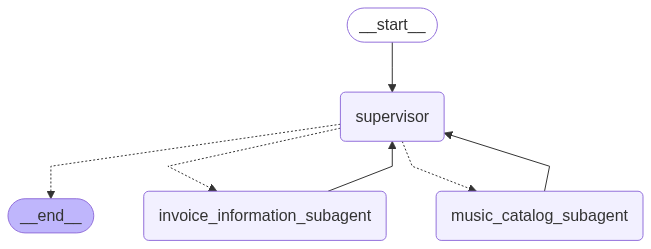

In [ ]:
from langgraph_supervisor import create_supervisor # 导入预构建的监督器创建器
# 使用 `create_supervisor` 工具创建监督器工作流
# 该函数动态设置图表以在提供的代理之间进行路由
supervisor_prebuilt_workflow = create_supervisor(
    agents=[invoice_information_subagent, music_catalog_subagent], # 监督器可以路由到的子代理列表
    output_mode="last_message", # 指定监督器应该只输出路由代理的最后一条消息
                               # 另一个选项是 "full_history" 获取子代理的所有消息
    model=llm,                # 作为监督器的LLM(用于路由决策)
    prompt=(supervisor_prompt), # 指导监督器行为的系统提示
    state_schema=State          # 整个多代理图的共享状态模式
)
# 将监督器工作流编译成可运行对象
# 这使其准备好被调用并与我们的内存系统集成
supervisor_prebuilt =

# Display a visualization of the compiled supervisor graph.
# Notice how the supervisor acts as the central hub, directing traffic to its sub-agents.
show_graph(supervisor_prebuilt)

#### 测试多代理监督系统
现在让我们测试我们新编译好的、带有监督代理的多代理系统。我们将提供一个可能涉及音乐和发票信息，或者主要涉及其中一个领域的问题，来观察监督代理如何正确地路由这个请求。


In [ ]:
thread_id = uuid.uuid4() # 为此对话生成一个新的线程ID

# 定义一个同时涉及发票和音乐信息的问题
question = "My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?"

# 使用线程ID配置调用
config = {"configurable": {"thread_id": thread_id}}

# 使用人类消息调用`supervisor_prebuilt`图
# 监督器将分析问题，将其路由到适当的子代理，
# 并从最后活动的代理返回最终响应

result = supervisor_prebuilt.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# Print the messages  mueerpreor_prebt_li_wtrklow.(nam="muic_catal_subgnt",ceckpin=kpoiesto=_memoy_sre)

#显示已编译的监督器图的可视化
#注意监督器如何作为中央枢纽，指导流量到其子代理

================================ Human Message =================================

My customer ID is 1. How much was my most recent purchase? What albums do you have by U2?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (chatcmpl-tool-a3d23fd642d24f06ad39ca12e6c2cd28)
 Call ID: chatcmpl-tool-a3d23fd642d24f06ad39ca12e6c2cd28
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_information_subagent

Your most recent purchase was on '2025-08-07 00:00:00' and the total amount was $8.91. Unfortunately, I am unable to provide information about U2 albums as it is not related to invoice information. Would you like to search for something else?
===============

## 第三部分：通过人机交互环节添加客户身份验证
目前，我们的代理假设 `customer_id` 是现成可用或直接包含在初始查询中的。在真实的客户支持场景中，在处理发票详情等敏感查询之前，我们通常需要**首先验证客户的身份**。这种验证可能涉及要求用户提供标识符（例如，电子邮件、电话、客户ID），然后在数据库中进行查找。
为了实现这一点，我们将引入一个**人机交互环节**（human-in-the-loop）组件。这意味着图（graph）可以*暂停*执行，并等待用户提供额外的输入（或人工客服的输入）后再继续。LangGraph 的 `interrupt` 机制非常适合这个用途。
![人机输入集成](images/human_input.png)
在本步骤中，我们将向工作流添加两个新节点：
*   **`verify_info` 节点**：此节点将尝试从用户输入中提取客户标识符，并将其与我们数据库中的信息进行验证。如果找到，它将更新图状态中的 `customer_id`。如果未找到或未提供，它将提示用户提供该信息。
*   **`human_input` 节点**：这是一个简单的节点，它会显式地触发一个 `interrupt`，暂停图的执行，直到用户提供必要的信息以恢复执行。
我们还将利用 LangChain 的结构化输出功能，使用 Pydantic 模式（schemas）来可靠地解析用户输入以获取标识符。


In [ ]:
from pydantic import BaseModel, Field # 使用Pydantic来定义数据模式和字段验证

# 定义一个Pydantic BaseModel来构建预期的用户账户信息输入结构
# 这有助于LLM从自由文本中解析特定实体(标识符)
class UserInput(BaseModel):
    """用于解析用户提供的账户信息的模式"""
    # `identifier`字段：期望一个字符串，包含LLM理解其用途的描述
    identifier: str = Field(description = "标识符，可以是客户ID、电子邮件或电话号码。")

# 使用`with_structured_output`将Pydantic模式绑定到LLM
# 这强制LLM生成符合`UserInput`模式的输出，使解析更可靠
structured_llm = llm.with_structured_output(schema=UserInput)

# 为结构化LLM定义系统提示
# 此提示指导LLM如何从消息中提取客户标识符
structured_system_prompt = """You are a customer service representative responsible for extracting customer identifier.\n 
Only extract the customer's account information from the message history. 
If they haven't provided the information yet, return an empty string for the file"""

In [ ]:
from typing import Optional # 用于类型提示可选值

# 辅助函数，通过各种标识符（ID、电话、邮箱）获取客户ID
def get_customer_id_from_identifier(identifier: str) -> Optional[int]:
    """
    使用标识符获取客户ID，标识符可以是客户ID、邮箱或电话号码
    
    参数:
        identifier (str): 标识符可以是客户ID、邮箱或电话
    
    返回:
        Optional[int]: 如果找到则返回客户ID，否则返回None
    """
    # 检查标识符是否为纯数字，表示直接使用客户ID
    if identifier.isdigit():
        return int(identifier)
    
    # 检查标识符是否以'+'开头，表示这是一个电话号码
    elif identifier[0] == "+":
        query = f"SELECT CustomerId FROM Customer WHERE Phone = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result) # 安全地将字符串转换为列表/元组
        if formatted_result:
            return formatted_result[0][0] # 返回找到的第一个客户ID
    
    # 检查标识符是否包含'@'，表示这是一个邮箱地址
    elif "@" in identifier:
        query = f"SELECT CustomerId FROM Customer WHERE Email = '{identifier}';"
        result = db.run(query)
        formatted_result = ast.literal_eval(result)
        if formatted_result:
            return formatted_result[0][0] # 返回找到的第一个客户ID
    
    # 如果没有找到匹配的标识符类型或未检索到ID，返回None
    return None


In [ ]:
# 定义 `verify_info` 节点函数
# 该节点负责根据用户输入验证客户身份
def verify_info(state: State, config: RunnableConfig):
    """验证客户账户,通过解析其输入并与数据库匹配"""

    # 检查状态中是否已存在 customer_id
    # 如果存在,则验证已完成,节点不执行任何操作(通过)
    if state.get("customer_id") is None: 
        # 验证 LLM 的系统指令
        system_instructions = """You are a music store agent, where you are trying to verify the customer identity 
        as the first step of the customer support process. 
        Only after their account is verified, you would be able to support them on resolving the issue. 
        In order to verify their identity, one of their customer ID, email, or phone number needs to be provided.
        If the customer has not provided the information yet, please ask them for it.
        If they have provided the identifier but cannot be found, please ask them to revise it."""

        # 从状态中获取最新的用户消息
        user_input = state["messages"][-1] 
    
        # 使用结构化 LLM 解析用户输入以获取标识符
        # 它将结构化系统提示与用户消息组合在一起
        parsed_info = structured_llm.invoke([SystemMessage(content=structured_system_prompt)] + [user_input])
    
        # 提取已识别的标识符字符串
        identifier = parsed_info.identifier
    
        customer_id = "" # 将 customer_id 初始化为空字符串
        # 使用辅助函数尝试在数据库中查找客户 ID
        if (identifier):
            customer_id = get_customer_id_from_identifier(identifier)
    
        # 如果找到有效的 customer_id
        if customer_id != "":
            # 创建确认验证的系统消息
            intent_message = SystemMessage(
                content= f"Thank you for providing your information! I was able to verify your account with customer id {customer_id}."
            )
            # 使用找到的 customer_id 和确认消息更新状态
            return {
                  "customer_id": customer_id,
                  "messages" : [intent_message]
                  }
        # 如果未找到或未提供 customer_id
        else:
          # 调用基础 LLM,指示用户提供标识符或修改标识符
          response = llm.invoke([SystemMessage(content=system_instructions)]+state['messages'])
          # 使用 LLM 的响应更新状态(提示用户输入)
          return {"messages": [response]}

    else: 
        # 如果状态中已存在 `customer_id`,则此节点不执行任何操作
        # 这个 `pass` 表示图将简单地继续到下一个边,
        # 如图编译中所定义
        pass

现在，让我们来创建我们的 `human_input` 节点。这个节点的设计目的是触发图（graph）中的一个 `中断`（interrupt）。当中断发生时，图会暂停执行，并将控制权交还给调用者（例如，Jupyter Notebook 或应用程序）。调用者随后可以选择恢复图的执行，并可选地提供新的输入。
这就是我们如何通过人机交互环节（human-in-the-loop）来实现客户身份验证：图会要求提供一个标识符，然后暂停并等待用户输入该信息。


In [ ]:
from langgraph.types import interrupt # 导入 `interrupt` 函数用于暂停图执行

# 定义 `human_input` 节点函数
# 该节点作为一个占位符，用于表示需要人工干预
def human_input(state: State, config: RunnableConfig):
    """ 这是一个需要被中断的空操作节点 """
    # `interrupt("Please provide input.")` 暂停图的执行
    # 字符串消息作为中断的原因传递
    # 当图恢复执行时，新的输入将被存储在 `user_input` 中
    user_input = interrupt("Please provide input.")
    
    # 新的用户输入（恢复后）被添加到状态中的消息列表中
    return {"messages": [user_input]}

现在让我们把这些整合起来！我们将把 `verify_info` 和 `human_input` 节点集成到一个新的图结构中。其流程如下：
1.  **`START`** -> **`verify_info`**：所有传入的查询首先尝试验证客户身份。
2.  **`verify_info` (条件边)**：
    *   如果 `customer_id` *未* 找到（意味着验证失败或输入待定），则路由到 **`human_input`**。
    *   如果 `customer_id` *已* 找到（意味着验证成功），则路由到 **`supervisor`**。
3.  **`human_input`** -> **`verify_info`**：在用户提供输入以恢复图执行后，它会路由回 `verify_info`，以便使用新的输入重新尝试验证。
4.  **`supervisor`** -> **`END`**：一旦主查询由监督代理及其子代理处理完毕，图就结束。

这种设置确保在执行任何其他操作之前先验证客户身份，并且能够妥善处理需要提供或重新尝试验证身份的情况



In [ ]:
# 定义 `verify_info` 的条件边缘函数
# 此函数检查状态中是否成功设置了 `customer_id`
def should_interrupt(state: State, config: RunnableConfig):
    # 如果存在 `customer_id`，说明验证成功或已完成，继续执行
    if state.get("customer_id") is not None:
        return "continue"
    # 否则，说明缺少客户ID或无法验证，中断并等待人工输入
    else:
        return "interrupt"

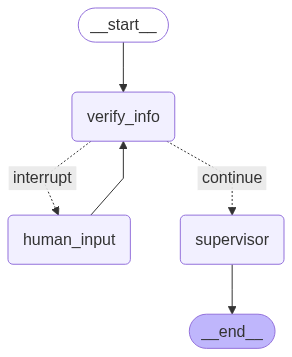

In [ ]:
# 为具有人机交互验证的多智能体系统初始化一个新的状态图
multi_agent_verify = StateGraph(State)

# 添加用于客户身份验证的 `verify_info` 节点
multi_agent_verify.add_node("verify_info", verify_info)

# 添加 `human_input` 节点，该节点触发中断以获取用户输入
multi_agent_verify.add_node("human_input", human_input)

# 添加 `supervisor` 节点，该节点负责协调查询处理的子代理
multi_agent_verify.add_node("supervisor", supervisor_prebuilt)

# 定义入口点：所有交互都从客户验证开始
multi_agent_verify.add_edge(START, "verify_info")

# 定义 `verify_info` 之后的条件路由
# `should_interrupt` 决定是继续到supervisor还是提示用户输入
multi_agent_verify.add_conditional_edges(
    "verify_info",     # 源节点
    should_interrupt,  # 条件函数
    {
        # 如果验证成功，继续到主管理代理
        "continue": "supervisor",
        # 如果需要验证（或验证失败），路由到 `human_input` 以提示用户
        "interrupt": "human_input",
    },
)

# `human_input` 之后（恢复后），循环回到 `verify_info` 重新尝试验证
multi_agent_verify.add_edge("human_input", "verify_info")

# supervisor 是图结束前的最后处理阶段
multi_agent_verify.add_edge("supervisor", END)

# 编译完整的图，将所有节点和边与我们的内存系统集成
multi_agent_verify_graph = multi_agent_verify.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)

# 显示新图的可视化
show_graph(multi_agent_verify_graph)

#### 测试人机交互环节验证
让我们来测试我们更新后的图。我们将从一个需要客户ID的问题开始，但最初不提供该ID。这应该会触发 `human_input` 节点并暂停执行。


In [ ]:
thread_id = uuid.uuid4() # 生成一个新的唯一线程ID

# 初始问题(未提供客户ID)
question = "How much was my most recent purchase?"

# 图调用的配置
config = {"configurable": {"thread_id": thread_id}}

# 调用图。第一次调用应该会命中`human_input`节点并中断
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 打印消息以观察代理请求客户ID的过程
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Before I can look up your most recent purchase, I need to verify your identity. Could you please provide me with your customer ID, email address, or phone number associated with your account? This will help me to access your information and assist you with your query.


In [ ]:
from langgraph.types import Command # 导入Command用于恢复图执行

# 现在，我们模拟用户提供他们的电话号码以恢复对话
question = "My phone number is +55 (12) 3923-5555."

# 使用`Command(resume=...)`从中断处恢复。
# `resume`参数携带新的用户输入，该输入将由`human_input`节点处理
# 然后传回给`verify_info`。
# `config`必须与初始调用相同，以恢复正确的线程。
result = multi_agent_verify_graph.invoke(Command(resume=question), config=config)

# 打印对话消息以查看验证和后续处理
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Before I can look up your most recent purchase, I need to verify your identity. Could you please provide me with your customer ID, email address, or phone number associated with your account? This will help me to access your information and assist you with your query.
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor

{"type": "function", "function": {"name": "transfer_to_invoice_information_subagent", "parameters": {}}}


在，如果我们**在同一线程**中提出一个后续问题，我们的代理状态（由检查点管理器管理）**已经存储了我们的 `customer_id`**。这意味着 `verify_info` 节点会直接 `pass`（跳过），而不会重新提示，查询将直接路由到监督代理，这展示了短期记忆的好处。


In [ ]:
# 在同一个线程中的后续问题(使用相同的 `thread_id`)
question = "What albums do you have by the Rolling Stones?"

# 再次调用图。由于 `customer_id` 已经在状态中，
# 验证步骤将被跳过，查询将直接转到主管
result = multi_agent_verify_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 打印结果。你将直接看到音乐目录子代理的响应
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

How much was my most recent purchase?
================================== Ai Message ==================================

Before I can look up your most recent purchase, I need to verify your identity. Could you please provide me with your customer ID, email address, or phone number associated with your account? This will help me to access your information and assist you with your query.
================================ Human Message =================================

My phone number is +55 (12) 3923-5555.
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor

{"type": "function", "function": {"name": "transfer_to_invoice_information_subagent", "parameters": {}}}
==========================

## 第四部分：添加长期记忆（用户偏好）
我们已经成功构建了一个能够处理验证和多代理执行的代理工作流。现在，让我们通过集成**长期记忆**来进一步增强它。虽然短期记忆（通过检查点管理器）能维持单次对话内的上下文，但长期记忆允许我们的代理在*不同对话之间*或针对同一用户的跨会话场景中存储和回忆信息。这对于个性化至关重要。
![记忆集成](images/memory.png)
在本步骤中，我们将添加两个新节点来管理与音乐相关的用户偏好：
*   **`load_memory` 节点**：该节点将从我们的长期记忆存储 `InMemoryStore` 中加载与已验证的 `customer_id` 关联的任何现有音乐偏好，并将其存入当前图的 `State`（`loaded_memory`）。这确保了代理在进行个性化回应时拥有相关的上下文信息。
*   **`create_memory` 节点**：在主查询处理完毕后，该节点将分析刚刚发生的对话。如果客户分享了任何新的音乐兴趣，它将更新或创建 `InMemoryStore` 中的 `UserProfile`，以便将这些偏好保存供未来交互使用。


In [ ]:
from langgraph.store.base import BaseStore # 为LangGraph定义自定义存储的基类

# 辅助函数，用于将用户记忆（音乐偏好）格式化为可读字符串
def format_user_memory(user_data):
    """Formats music preferences from users, if available."""
    profile = user_data['memory'] # 从存储的字典中访问'memory'键
    result = "" # 初始化一个空字符串作为格式化结果
    
    # 检查profile对象是否有'music_preferences'属性且不为空
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        # 如果存在偏好，将它们连接成逗号分隔的字符串
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    
    return result.strip() # 返回格式化的字符串，删除任何前导/尾随空格

# 定义`load_memory`节点函数
# 该节点将用户的长期记忆（音乐偏好）加载到当前状态
def load_memory(state: State, config: RunnableConfig, store: BaseStore):
    """Loads music preferences from users, if available."""
    
    user_id = state["customer_id"] # 从状态中获取当前客户ID
    namespace = ("memory_profile", user_id) # 定义用于存储用户特定记忆的命名空间
                                          # 这为每个用户的配置文件创建唯一的键
    
    # 尝试从`InMemoryStore`中检索此用户的现有记忆
    existing_memory = store.get(namespace, "user_memory")
    
    formatted_memory = "" # 初始化格式化的记忆为空
    
    # 如果记忆存在且有值，使用我们的辅助函数格式化它
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    # 使用检索到的格式化记忆更新状态中的`loaded_memory`字段
    return {"loaded_memory" : formatted_memory}

In [ ]:
# 定义一个Pydantic BaseModel来构建`UserProfile`用于长期记忆存储
# 这确保了用户偏好能以一致且可验证的格式进行存储
class UserProfile(BaseModel):
    # `customer_id`: 客户唯一标识符的必填字段
    customer_id: str = Field(
        description="The customer ID of the customer"
    )
    # `music_preferences`: 用于存储客户音乐兴趣的字符串列表
    music_preferences: List[str] = Field(
        description="The music preferences of the customer"
    )

In [ ]:
# 为 `create_memory` LLM 定义系统提示。
# 该提示指示 LLM 作为分析师，分析对话历史
# 以提取并更新结构化 `UserProfile` 格式中的用户音乐偏好。
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request.
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 

Take a deep breath and think carefully before responding.
"""

# 定义 `create_memory` 节点函数
# 该节点负责分析对话并保存/更新用户音乐偏好
def create_memory(state: State, config: RunnableConfig, store: BaseStore):
    user_id = str(state["customer_id"]) # 从当前状态获取客户ID(转换为字符串)
    namespace = ("memory_profile", user_id) # 为该用户的内存配置文件定义命名空间
    
    # 从长期存储中检索该用户的现有内存配置文件
    existing_memory = store.get(namespace, "user_memory")
    
    formatted_memory = "" # 初始化用于提示的格式化内存
    if existing_memory and existing_memory.value:
        existing_memory_dict = existing_memory.value # 获取包含UserProfile实例的字典
        # 将现有音乐偏好格式化为提示字符串
        formatted_memory = (
            f"Music Preferences: {', '.join(existing_memory_dict.get('memory').music_preferences or [])}" # 通过'memory'键访问UserProfile对象
        )

    # 创建格式化的系统消息，注入完整的对话历史记录和现有的内存配置文件
    formatted_system_message = SystemMessage(content=create_memory_prompt.format(conversation=state["messages"], memory_profile=formatted_memory))
    
    # 使用结构化输出(UserProfile)调用LLM来分析对话并根据新信息更新内存配置文件
    updated_memory = llm.with_structured_output(UserProfile).invoke([formatted_system_message])
    
    key = "user_memory" # 定义用于存储此特定内存对象的键
    
    # 将更新的内存配置文件存储回InMemoryStore中
    # 我们将updated_memory包装在'memory'键下的字典中以保持访问的一致性
    store.put(namespace, key, {"memory": updated_memory})

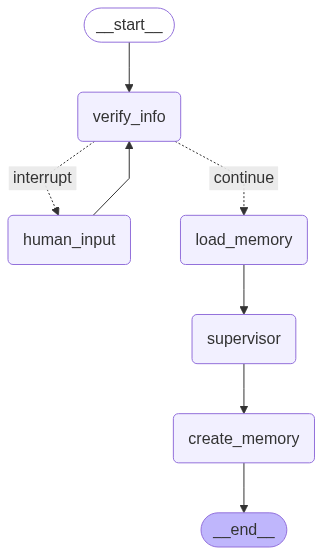

In [ ]:
# 初始化包含内存管理的完整多智能体系统的最终状态图
multi_agent_final = StateGraph(State)

# 向图中添加所有必要的节点
multi_agent_final.add_node("verify_info", verify_info)         # 客户验证节点
multi_agent_final.add_node("human_input", human_input)         # 人工干预中断节点
multi_agent_final.add_node("load_memory", load_memory)         # 加载用户长期记忆节点
multi_agent_final.add_node("supervisor", supervisor_prebuilt)   # 子智能体路由的监督节点
multi_agent_final.add_node("create_memory", create_memory)     # 保存/更新用户长期记忆节点

# 定义初始入口点：所有交互都从验证开始
multi_agent_final.add_edge(START, "verify_info")

# 定义verify_info之后的条件路由
# 如果验证成功，继续加载记忆；否则，提示人工输入
multi_agent_final.add_conditional_edges(
    "verify_info",
    should_interrupt,
    {
        "continue": "load_memory", # 如果验证通过，加载用户记忆
        "interrupt": "human_input", # 如果验证失败，请求人工输入
    },
)

# human_input(恢复)之后，循环回到verify_info重新尝试验证
multi_agent_final.add_edge("human_input", "verify_info")

# 加载记忆后，进入supervisor进行主要查询处理
multi_agent_final.add_edge("load_memory", "supervisor")

# supervisor完成后，保存/更新用户的记忆
multi_agent_final.add_edge("supervisor", "create_memory")

# 更新记忆后图结束
multi_agent_final.add_edge("create_memory", END)

# 编译整个复杂的图
multi_agent_final_graph = multi_agent_final.compile(name="multi_agent_verify", checkpointer=checkpointer, store=in_memory_store)

# 显示完整图的可视化
show_graph(multi_agent_final_graph)

让我们来测试一下！我们将使用一个复杂的查询，该查询需要身份验证，然后会涉及到音乐和发票信息，并且还包含一个应该保存到长期记忆中的音乐偏好。


In [ ]:
thread_id = uuid.uuid4() # 为此演示生成一个新的唯一线程ID

# 包含客户ID、发票查询和音乐偏好的综合问题
question = "My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?"

# 图调用的配置
# 注意：user_id作为可配置参数传递，尽管在这个特定示例中，
# customer_id是由verify_info节点动态提取的。
# 对于实际使用，确保用户标识符的一致处理。
config = {"configurable": {"thread_id": thread_id, "user_id" : "1"}}

# 调用最终的多代理图
# 这将经过验证、内存加载、主管路由（先发票后音乐）、
# 最后进行内存保存
result = multi_agent_final_graph.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 打印最终状态中的所有消息以观察完整的交互流程
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My phone number is +55 (12) 3923-5555. How much was my most recent purchase? What albums do you have by the Rolling Stones?
================================ System Message ================================

Thank you for providing your information! I was able to verify your account with customer id 1.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_invoice_information_subagent (chatcmpl-tool-a844b8368cb64dd5ad927db45f75ffb6)
 Call ID: chatcmpl-tool-a844b8368cb64dd5ad927db45f75ffb6
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_subagent

Successfully transferred to invoice_information_subagent
================================== Ai Message ==================================
Name: invoice_information_subagent

Your most recent purchase was on August 7, 202

让我们看看记忆存储！我们预期音乐偏好（例如，'滚石乐队'）会以电话号码 `+55 (12) 3923-5555` 关联的客户ID（在我们Chinook数据库中对应客户ID 1）为索引，保存在我们的 `in_memory_store` 中。


In [ ]:
user_id = "1" # 我们期望与使用的电话号码相关联的客户ID
namespace = ("memory_profile", user_id) # 用于存储此用户内存的命名空间

# 从 `in_memory_store` 获取用户的内存配置
# `.value` 获取存储的实际数据，应该是包含 UserProfile 实例的字典
memory_data = in_memory_store.get(namespace, "user_memory")

# 检查 memory_data 是否存在并具有 'memory' 键(该键存储 UserProfile 对象)
if memory_data and "memory" in memory_data.value:
    saved_music_preferences = memory_data.value.get("memory").music_preferences
else:
    saved_music_preferences = [] # 如果未找到偏好设置，默认为空列表

print(f"Saved Music Preferences for Customer ID {user_id}: {saved_music_preferences}")

Saved Music Preferences for Customer ID 1: ['Rolling Stones']


## （可选）构建一个蜂群多代理图
除了集中式监督者模式之外，多代理系统的另一种强大方法是**蜂群架构（Swarm architecture）**。虽然监督者依赖于一个单一协调代理，但蜂群模型强调去中心化协作。
### 蜂群架构
![蜂群架构](images/swarm.png) 
在蜂群中，多个专业化的代理在没有中央协调器的情况下协同工作。每个代理都了解其他代理的能力，并在自身专业知识不足或查询跨越领域时，能够*直接将任务交接*给最合适的同伴。这创造了一种灵活、动态的流程，代理们根据需要相互传递控制权。
在LangChain，我们构建了一个[轻量级库](https://github.com/langchain-ai/langgraph-swarm-py)来帮助人们轻松地使用LangGraph创建蜂群代理。
### 蜂群 vs 监督者
![蜂群与监督者比较](images/supervisor_vs_swarm.png)
让我们回顾一下关键差异：
| 特性             | 监督者架构                                       | 蜂群架构                                       |
| :--------------- | :----------------------------------------------- | :--------------------------------------------- |
| **控制流**       | 集中式；监督者路由查询。                          | 去中心化；代理相互交接。                          |
| **决策制定**     | 监督者决定下一个调用哪个代理。                    | 每个代理决定交给谁。                              |
| **层级结构**     | 清晰的层级：监督者 -> 子代理。                    | 平坦、协作的结构。                              |
| **模块化**       | 通过更新监督者来添加/移除子代理。                  | 代理需要了解可能的交接对象。                      |
| **可预测性**     | 路由更可预测。                                  | 更动态，具有涌现行为。                          |
| **容错性**       | 监督者是单点故障。                              | 对单个代理故障更具韧性。                          |

选择监督者还是蜂群取决于你的用例。如果你需要严格的控制和清晰的流程，监督者通常更合适。如果你的问题能从动态、协作的问题解决和更强的适应性中受益，蜂群可能更合适。

更多相关信息，我们团队在LangChain的Lance有一个很棒的视频，详细讲解了监督者与蜂群的区别：[使用LangGraph构建多代理蜂群](https://www.youtube.com/watch?v=JeyDrn1dSUQ)
现在，让我们来创建蜂群代理吧！


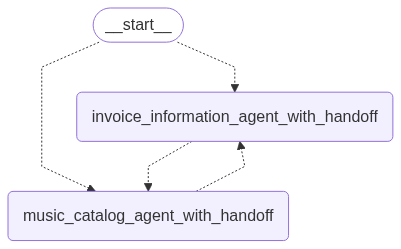

In [ ]:
from langgraph_swarm import create_handoff_tool, create_swarm # 导入用于创建群体智能代理和交接工具的实用程序

# 在代理之间创建交接工具
# 这些是特殊工具，当代理调用时，会向群体中的另一个指定代理发出控制权转移的信号

transfer_to_invoice_agent_handoff_tool = create_handoff_tool(
    agent_name = "invoice_information_agent_with_handoff", # 此交接的目标代理名称
    description = "Transfer user to the invoice information agent that can help with invoice information" # 用于LLM的描述
)

transfer_to_music_catalog_agent_handoff_tool = create_handoff_tool(
    agent_name = "music_catalog_agent_with_handoff", 
    description = "Transfer user to the music catalog agent that can help with music searches and music catalog information"
)

# 重新创建我们的代理，但这次将交接工具添加到它们可用的工具中
# 这允许每个代理在适当的时候向其他代理"请求"交接

# 首先，将交接工具与每个代理现有的特定工具组合
invoice_tools_with_handoff = [transfer_to_music_catalog_agent_handoff_tool] + invoice_tools
music_tools_with_handoff = [transfer_to_invoice_agent_handoff_tool] + music_tools

# 使用原始提示和新的工具集（包括交接）重新创建发票信息代理
invoice_information_agent_with_handoff = create_react_agent(
    llm,
    invoice_tools_with_handoff,
    prompt = invoice_subagent_prompt,
    name = "invoice_information_agent_with_handoff" # 为群体指定一个特定名称
)

# 使用原始提示和新的工具集（包括交接）重新创建音乐目录代理
# 注意：音乐目录代理提示是动态生成的，如前所述
music_catalog_agent_with_handoff = create_react_agent(
    llm,
    music_tools_with_handoff,
    prompt = generate_music_assistant_prompt(),
    name = "music_catalog_agent_with_handoff" # 为群体指定一个特定名称
)


# 创建群体工作流。`create_swarm`处理代理之间无需中央监督的交接编排逻辑
swarm_workflow = create_swarm(
    agents = [invoice_information_agent_with_handoff, music_catalog_agent_with_handoff], # 参与群体的代理
    default_active_agent = "invoice_information_agent_with_handoff", # 默认首先激活的代理
)

# 编译群体图。这使其可运行并集成内存
swarm_agents = swarm_workflow.compile(
    checkpointer = checkpointer,
    store = in_memory_store
)

# 显示群体的图。注意它与监督者图不同，
# 显示潜在交接的连接而不是中央枢纽
show_graph(swarm_agents)

现在我们来测试一下！我们将给它一个与音乐相关的问题，但由于 `default_active_agent` 设置为发票代理，它应该会将任务 *交接* 给音乐目录代理。


In [ ]:
# 为这个群体测试创建一个新线程
thread_id = uuid.uuid4()

# 提出一个音乐相关的问题
question = "Do you have any albums by the Rolling Stones?"

# 使用线程ID配置调用
config = {"configurable": {"thread_id": thread_id}}

# 调用群体代理。尽管默认活动代理是 `invoice_information_agent_with_handoff`，
# 它应该识别出这是一个音乐查询并转交给 `music_catalog_agent_with_handoff`
result = swarm_agents.invoke({"messages": [HumanMessage(content=question)]}, config=config)

# 打印消息以观察转交过程和最终响应
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Do you have any albums by the Rolling Stones?
================================== Ai Message ==================================
Name: invoice_information_agent_with_handoff
Tool Calls:
  transfer_to_music_catalog_agent_with_handoff (chatcmpl-tool-8a7be67fc82b486182797d3e7488d124)
 Call ID: chatcmpl-tool-8a7be67fc82b486182797d3e7488d124
  Args:
================================= Tool Message =================================
Name: transfer_to_music_catalog_agent_with_handoff

Successfully transferred to music_catalog_agent_with_handoff
================================== Ai Message ==================================
Name: music_catalog_agent_with_handoff
Tool Calls:
  get_albums_by_artist (chatcmpl-tool-b7048f07fe3b43b2aaf1a2ac1fcafd66)
 Call ID: chatcmpl-tool-b7048f07fe3b43b2aaf1a2ac1fcafd66
  Args:
    artist: Rolling Stones
================================= Tool Message =================================
Na

## 评估
**评估**是一种定性和系统化的方法，用于衡量您的LLM应用程序（尤其是代理）的性能。评估之所以至关重要，是因为LLM的行为并不总是可预测的——即使提示、模型或输入发生微小的变化，也可能显著影响结果。评估提供了一种结构化的方法来：
1.  **识别失败点**：找出代理在何处以及为何未能按预期工作。
2.  **比较版本**：定量地比较应用程序的不同版本（例如，在提示更改、模型更新或架构调整之后）。
3.  **构建可靠性**：逐步改进代理的质量，并确保其达到预期的性能基准。
一次评估通常包含三个核心组成部分：
1.  **数据集**：一组测试输入及其对应的预期输出（真实值）。这作为基准，用于衡量您的应用程序性能。
2.  **应用程序或目标函数**：您想要评估的LLM应用程序的特定部分（例如，一个代理、一个链或一个节点）。该函数接收输入并返回输出。
3.  **评估器**：指标或模型（通常是LLM本身，被称为“LLM作为裁判”），用于将目标函数的输出与数据集的真实值或特定标准进行评分。
![评估概念图](images/evals-conceptual.png) 
根据您想要衡量代理性能的方面，评估代理的方法有很多种。今天，我们将介绍三种常见的代理评估类型：
1.  **最终响应评估**：评估代理对用户查询的最终答案的质量，将代理视为一个黑盒。
2.  **单步评估**：关注代理执行过程中某个特定、关键步骤的性能（例如，它是否正确选择了工具）。
3.  **轨迹评估**：分析代理采取的整个步骤序列（即“轨迹”），评估其是否遵循了预期的工具调用和内部推理路径。


### 评估最终响应
评估最终响应是最常见且通常最简单的方法，用以衡量代理的整体有效性。这种方法将代理视为一个“黑盒”，并且只关注最终的输出是否成功解决了用户的意图，而不管其采取了哪些中间步骤。
*   **输入**：原始的用户查询。
*   **输出**：代理最终面向用户的响应。
![最终响应评估](images/final-response.png)



#### 1. 创建用于最终响应评估的数据集
我们将使用 LangSmith 来创建和管理我们的评估数据集。一个数据集由 `inputs`（用户问题）和 `outputs`（预期的正确响应）组成。这个“ ground truth”（基准真值）让评估者能够将代理生成的响应与被认为正确的响应进行比较。


In [ ]:
from langsmith import Client # 导入 LangSmith 客户端用于数据集和实验管理

client = Client() # 初始化 LangSmith 客户端。这将连接到你的 LangSmith 账户。

# 为我们的数据集定义示例输入和预期输出的列表。
# 每个字典代表一个测试用例，包含'question'(输入)和'response'(真实输出)。
examples = [
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "response": "The Invoice ID of your most recent purchase was 342.",
    },
    {
        "question": "I'd like a refund.",
        "response": "I need additional information to help you with the refund. Could you please provide your customer identifier so that we can fetch your purchase history?",
    },
    {
        "question": "Who recorded Wish You Were Here again?",
        "response": "Wish You Were Here is an album by Pink Floyd",
    },
    { 
        "question": "What albums do you have by Coldplay?",
        "response": "There are no Coldplay albums available in our catalog at the moment.",
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Final Response" # Define a name for our dataset.
# 检查数据集是否已存在于 LangSmith 中以避免重复创建
if not client.has_dataset(dataset_name=dataset_name):
    # 如果不存在，创建新数据集
    dataset = client.create_dataset(dataset_name=dataset_name)
    # 使用示例填充数据集
    # `inputs` 从 'question' 键中提取，`outputs` 从 'response' 键中提取
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"response": ex["response"]} for ex in examples],
        dataset_id=dataset.id # 将示例与创建的数据集关联
    )

#### 2. 定义待评估的应用逻辑
我们需要一个函数来封装我们 LangGraph 的执行过程，并以适合评估的格式返回最终响应。由于我们的图（graph）包含一个用于客户身份验证的 `human_input` 中断，因此我们必须在我们的评估函数中处理这一点。我们将模拟用户提供他们的客户ID（例如，“我的客户ID是10”）来让图能够通过验证步骤继续执行。


In [ ]:
import uuid # 用于生成唯一的线程ID
from langgraph.types import Command # 用于中断后恢复图执行

graph = multi_agent_final_graph # 引用我们完整的最终多代理图

async def run_graph(inputs: dict):
    """Run graph and track the final response for evaluation."""
    # 为每次评估运行创建唯一的线程ID以确保隔离
    thread_id = uuid.uuid4()
    # 图调用的配置。这里使用用户ID '10'作为特定测试场景
    configuration = {"configurable": {"thread_id": thread_id, "user_id" : "10"}}

    # 使用初始用户问题调用图
    # 如果没有customer_id，这次调用可能会在human_input节点处中断
    result = await graph.ainvoke({"messages": [
        { "role": "user", "content": inputs['question']}]}, config = configuration)
    
    # 第一次调用后，如果发生中断，则恢复它
    # 我们显式提供一个(模拟的)客户ID来通过验证步骤
    # 配置中的thread_id必须与初始调用匹配才能恢复正确的状态
    result = await graph.ainvoke(Command(resume="My customer ID is 10"), config={"configurable": {"thread_id": thread_id, "user_id" : "10"}})
    
    # 返回对话中最后一条消息的内容作为最终响应
    # 这个输出将与数据集的response进行评估对比
    return {"response": result['messages'][-1].content}

#### 3. 定义最终响应的评估器
评估器是函数，它们接收应用程序的输出、原始输入，有时还包括参考输出，然后返回一个分数或反馈。我们可以使用预构建的评估器，也可以定义自己的评估器。
##### 使用预构建的评估器（OpenEvals）
LangSmith 集成了 `openevals` 库，该库提供了一系列现成的、以LLM作为裁判的评估器。`create_llm_as_judge` 函数设置了一个评估器，该评估器使用一个LLM根据给定的提示（例如，`CORRECTNESS_PROMPT`）来对响应进行评分。
##### 定义自定义评估器（以LLM作为裁判）
为了满足更具体或更细微的评估标准，您可以定义自己的以LLM作为裁判的评估器。这包括：
1.  **自定义指令**：一个详细的提示，用于向LLM解释其作为评分者的角色以及评分标准。
2.  **结构化输出模式**：一个Pydantic `BaseModel` 或 `TypedDict`，用于强制LLM评分输出的格式（例如，`is_correct: bool`，`reasoning: str`）。
3.  **评估器函数**：一个Python函数，该函数使用提示、输入和参考输出来调用结构化的LLM，然后提取相关的分数。
这种方法为您提供了最大的灵活性，可以控制如何评判您的代理的响应。


In [ ]:
from openevals.llm import create_llm_as_judge # 导入创建LLM评判器的工具
from openevals.prompts import CORRECTNESS_PROMPT # 导入用于正确性评估的预定义提示

# 使用预构建的 `CORRECTNESS_PROMPT` 创建一个用于正确性评估的LLM评判器
# `feedback_key="correctness"` 设置在LangSmith中报告的分数名称
# `judge=model` 指定用于评判的LLM模型
correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=llm,
)

# 打印预定义正确性提示的内容以理解其指令
print(CORRECTNESS_PROMPT)

You are an expert data labeler evaluating model outputs for correctness. Your task is to assign a score based on the following rubric:

<Rubric>
  A correct answer:
  - Provides accurate and complete information
  - Contains no factual errors
  - Addresses all parts of the question
  - Is logically consistent
  - Uses precise and accurate terminology

  When scoring, you should penalize:
  - Factual errors or inaccuracies
  - Incomplete or partial answers
  - Misleading or ambiguous statements
  - Incorrect terminology
  - Logical inconsistencies
  - Missing key information
</Rubric>

<Instructions>
  - Carefully read the input and output
  - Check for factual accuracy and completeness
  - Focus on correctness of information rather than style or verbosity
</Instructions>

<Reminder>
  The goal is to evaluate factual correctness and completeness of the response.
</Reminder>

<input>
{inputs}
</input>

<output>
{outputs}
</output>

Use the reference outputs below to help you evaluate the

In [ ]:
# 自定义 LLM 作为评判者的指令
# 此提示为 LLM 作为评分者提供具体指导，重点关注事实准确性
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# 使用 TypedDict 定义 LLM 评判输出的模式
# 确保评分输出包含推理过程和布尔型正确性得分
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# 配置评判 LLM 以根据 `Grade` 模式输出结构化数据
# `method="json_schema"` 确保基于 JSON 的结构化输出，`strict=True` 强制严格遵守
grader_llm = llm.with_structured_output(Grade, method="json_schema", strict=True)

# 定义自定义评估函数 `final_answer_correct`
# 该函数接收输入、输出（来自 `run_graph`）和参考输出（来自数据集）
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    # 构建评判 LLM 的用户提示，结合问题、标准答案和学生回答
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    # 使用系统指令和用户提示调用结构化评判 LLM
    # 由于 LLM 调用通常是异步的，需要等待异步调用完成
    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    
    # 从评判输出中返回 `is_correct` 布尔值作为评估分数
    return grade["is_correct"]

#### 4. 执行最终响应评估
现在，我们准备好使用 LangSmith 客户端来运行我们的评估任务。`aevaluate` 方法负责协调整个过程：
1.  它从指定的 `data`（我们的数据集）中获取输入。
2.  对于每个输入，它会调用我们的 `run_graph` 函数。
3.  然后，它将 `run_graph` 的输出，连同原始输入和数据集的参考输出，传递给每个定义好的 `evaluator`。
4.  所有结果都会被记录下来，并在您的 LangSmith 项目中可见，从而提供一份关于代理性能的全面报告。
关键参数：
*   `run_graph`：我们待评估的目标函数。
*   `data`：在 LangSmith 中创建的数据集的名称。
*   `evaluators`：要应用的评估器函数列表。
*   `experiment_prefix`：在 LangSmith 中实验名称的前缀，有助于组织运行。
*   `num_repetitions`：每个示例运行多少次。（为了获得更稳健的结果，通常 >1）
*   `max_concurrency`：最大并行运行数（有助于加快评估速度）。
完成之后，您可以导航到您的 LangSmith 项目，查看详细的追踪信息和汇总分数。


In [ ]:
# 使用 LangSmith 客户端异步运行评估任务
    # 这将对数据集中的每个示例执行 `run_graph` 并应用指定的评估器
experiment_results = await client.aevaluate(
    run_graph,                        # 运行图并返回其输出的异步函数
    data=dataset_name,                # 用于输入和参考的 LangSmith 数据集名称
    evaluators=[final_answer_correct, correctness_evaluator], # 要应用的评估器函数列表
    experiment_prefix="agent-Llama-e2e", # LangSmith 中实验名称的前缀，用于更好的组织
    num_repetitions=1,                # 运行每个示例的次数（1用于快速测试）
    max_concurrency=5,                # 最大并发运行数以优化评估速度
)

C:\Users\zax\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'agent-Llama-e2e-4673c9ed' at:
https://smith.langchain.com/o/d348e090-15af-44aa-adc7-192297a9682d/datasets/e46e8a71-8368-451b-b39f-0f008ce171c2/compare?selectedSessions=76324224-4b0e-484f-bb7e-2b762d318274




3it [03:01, 54.81s/it] Error running target function: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
Traceback (most recent call last):
  File "C:\Users\zax\AppData\Roaming\Python\Python312\site-packages\langsmith\evaluation\_arunner.py", line 1239, in _aforward
    await fn(
  File "C:\Users\zax\AppData\Roaming\Python\Python312\site-packages\langsmith\run_helpers.py", line 535, in async_wrapper
    function_result = await asyncio.create_task(  # type: ignore[call-arg]
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zax\AppData\Local\Temp\ipykernel_33316\1774738166.py", line 15, in run_graph
    result = await graph.ainvoke({"messages": [
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zax\AppData\Roaming\Python\Python312\site-packag

### 评估代理的单个步骤
虽然端到端评估很重要，但它可能难以进行调试。有时，代理可能整体失败，但你不知道是*哪个*特定的决策或操作导致了失败。**单步评估**允许你像软件开发中的单元测试一样，隔离地测试代理工作流中的单个组件或关键决策。
对于我们的多代理系统，一个关键的单步是**监督者的路由决策**：它是否正确地将查询发送给音乐代理或发票代理？
*   **输入**：该单个步骤的特定输入（例如，监督者收到的用户消息）。
*   **输出**：该步骤的直接输出（例如，监督者选择路由到的代理名称）。
![单步评估](images/single-step.png)


#### 1. 创建单步评估的数据集
对于单步评估，我们数据集中的 `inputs` 将是用户消息，而 `outputs` 将是*预期的路由决策*（即应该被激活的子代理的名称）。


In [ ]:
# 定义单步评估示例，重点关注主管的路由分配
    # `messages`: 主管的输入(用户查询)
    # `route`: 主管的预期输出(应该路由到的子代理名称)
examples = [
    {
        "messages": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?", 
        "route": 'transfer_to_invoice_information_subagent' # Expects initial routing to invoice agent
    },
    {
        "messages": "What songs do you have by U2?", 
        "route": 'transfer_to_music_catalog_subagent' # Expects routing to music agent
    },
    {
        "messages": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?", 
        "route": 'transfer_to_invoice_information_subagent' # Expects routing to invoice agent
    },
    {
        "messages": "Who recorded Wish You Were Here again? What other albums by them do you have?", 
        "route": 'transfer_to_music_catalog_subagent' # Expects routing to music agent
    }
]


dataset_name = "LangGraph 101 Multi-Agent: Single-Step" # 此特定数据集的名称
# 检查LangSmith中是否已存在数据集，如果不存在则创建
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs = [{"messages": ex["messages"]} for ex in examples],
        outputs = [{"route": ex["route"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. 定义要评估的应用逻辑（单步）
为了仅评估监督者的路由决策，我们需要运行我们的 `supervisor_prebuilt` 图，但在监督者做出路由决策后、在任何子代理实际被调用之前，*中断*其执行。LangGraph 的 `interrupt_before` 参数非常适合这个目的。
`interrupt_before` 参数告诉图在进入指定节点之前暂停执行。在这种情况下，我们希望在调用 `music_catalog_subagent` 或 `invoice_information_subagent` 之前暂停。这使我们能够检查状态并确定监督者决定做什么。


In [ ]:
async def run_supervisor_routing(inputs: dict):
    """Runs the supervisor graph up to the point of routing and returns the chosen route."""
    # 调用 `supervisor_prebuilt` 图
    # `interrupt_before` 指定图在进入音乐或发票子代理节点之前暂停执行，这样可以捕获路由决策
    # 提供了虚拟的 `user_id` 和 `thread_id` 用于配置，因为supervisor本身不需要真实的验证
    result = await supervisor_prebuilt.ainvoke(
        {"messages": [HumanMessage(content=inputs['messages'])]},
        interrupt_before=["music_catalog_subagent", "invoice_information_subagent"],
        config={"configurable": {"thread_id": uuid.uuid4(), "user_id" : "10"}}
    )
    
    # 最后一条消息的名称（通常是表示路由决策的 `tool_call` 或 `message`）
    # 应该对应于下一个选择的子代理的名称。这就是supervisor指示其路由的方式
    return {"route": result["messages"][-1].name}

#### 3. 定义单步评估的评估器
对于这种单步评估，一个简单的精确匹配评估器就足够了。它将检查我们 `run_supervisor_routing` 函数输出的 `route` 是否与数据集中 `reference_outputs` 中定义的 `route` 完全匹配。


In [ ]:
def correct(outputs: dict, reference_outputs: dict) -> bool:
    """评估函数，用于检查代理是否选择了正确的路线。"""
    # 比较由 `run_supervisor_routing` 函数返回的 'route' 
    # 与地面实况数据集中指定的 'route'
    return outputs['route'] == reference_outputs["route"]

#### 4. 执行单步评估
现在我们使用 `client.aevaluate` 来执行单步评估，这与最终响应评估类似，但使用了我们特定的函数和数据集。


In [43]:
experiment_results = await client.aevaluate(
    run_supervisor_routing,           # Our function that runs only the supervisor routing step
    data=dataset_name,                # The dataset specifically for single-step routing evaluation
    evaluators=[correct],
    experiment_prefix="agent-Llama-singlestep",
    max_concurrency=5,
)

View the evaluation results for experiment: 'agent-Llama-singlestep-bca8c84a' at:
https://smith.langchain.com/o/d348e090-15af-44aa-adc7-192297a9682d/datasets/0c7eedb8-eb2a-41ca-bc83-88224ebdaf23/compare?selectedSessions=e1835bfa-c9e2-4de0-8e63-f48e08e999cc




4it [00:03,  1.25it/s]


### 评估代理的执行轨迹
**轨迹评估**会深入考察代理的内部运作过程。它不像只评估最终输出或单个步骤那样，而是评估代理为了得出答案所经历的整个步骤序列（即“轨迹”）。这对于复杂代理尤其有用，因为在这些代理中，*达成解决方案的过程*与解决方案本身同样重要（例如，确保特定的一组工具按照特定顺序被使用）。
*   **输入**：发送给整个代理的初始用户查询。
*   **输出**：代理执行过程中访问过的所有节点/步骤的详细列表。
![轨迹评估](images/trajectory.png)


#### 1. 创建用于轨迹评估的数据集
对于轨迹评估，我们的数据集将包含用户 `question`（问题）作为输入，以及一个有序的 `trajectory`（即预期的节点名称序列）列表作为基准真值输出。


In [ ]:
# 定义用于轨迹评估的示例
    # `question`: 用户输入
    # `trajectory`: 图中预期访问的节点名称的有序列表
examples = [
    {
        "question": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"], # Expected path when customer ID is provided
    },
    {
        "question": "What songs do you have by U2?",
        "trajectory": ["verify_info", "human_input", "verify_info", "load_memory", "supervisor", "create_memory"], # Expected path with initial verification and resume
    },
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "trajectory": ["verify_info", "load_memory", "supervisor", "create_memory"], # Expected path when customer ID is provided implicitly
    },
    {
        "question": "Who recorded Wish You Were Here again? What other albums by them do you have?",
        "trajectory": ["verify_info", "human_input", "verify_info", "load_memory", "supervisor", "create_memory"], # Another example with initial verification and resume
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Trajectory Eval" # Name for this dataset.

# 如果数据集在 LangSmith 中不存在则检查并创建
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"trajectory": ex["trajectory"]} for ex in examples],
        dataset_id=dataset.id
    )

#### 2. 定义要评估的应用逻辑（轨迹）
为了捕获完整的执行轨迹，我们将使用 `graph.astream(stream_mode="debug")`。`debug` 流模式会为图中的每一步生成详细的 `chunk` 对象，其中包括 `task` chunks，这些 chunks 包含了正在执行的节点名称。我们将收集这些节点名称到一个列表中，以形成实际的执行轨迹。
与最终响应评估类似，我们需要处理 `human_input` 中断，方法是使用虚拟输入来恢复图的执行。


In [ ]:
graph = multi_agent_final_graph # 引用我们完整的多智能体图

async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = [] # 用于存储已访问节点名称的列表
    thread_id = uuid.uuid4() # 当前线程的唯一ID
    # 图调用的配置，包含用于验证步骤的虚拟user_id
    configuration = {"configurable": {"thread_id": thread_id, "user_id" : "10"}}

    # 首先，运行图来处理初始问题。`astream`允许我们遍历数据块
    # `stream_mode="debug"`提供每个步骤的详细信息，包括节点名称
    async for chunk in graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, config = configuration, stream_mode="debug"):
        # 检查数据块类型是否为'task'（表示节点执行）
        if chunk['type'] == 'task':
            # 将执行的节点名称添加到我们的轨迹列表中
            trajectory.append(chunk['payload']['name'])

    # 如果图因等待人工输入而暂停，则使用虚拟客户ID继续执行
    async for chunk in graph.astream(Command(resume="My customer ID is 10"), config = configuration, stream_mode="debug"):
        if chunk['type'] == 'task':
            trajectory.append(chunk['payload']['name'])
            
    # 返回收集的轨迹列表
    return {"trajectory": trajectory}

#### 3. 定义轨迹评估器
对于轨迹评估，我们将定义两个自定义评估器：
1.  **`evaluate_exact_match`**：这个简单的评估器检查 `实际轨迹` 是否与数据集中的 `预期轨迹` 完全匹配。它提供一个二元分数（True/False）。
2.  **`evaluate_extra_steps`**：这个更复杂的评估器计算代理执行了多少个在参考轨迹中不存在的“未匹配”或“额外”步骤。这可能表明效率低下或出现了意外行为。


In [ ]:
def evaluate_exact_match(outputs: dict, reference_outputs: dict):
    """Evaluate whether the trajectory exactly matches the expected output"""
    return {
        "key": "exact_match", # 此评估指标在 LangSmith 中的键名
        "score": outputs["trajectory"] == reference_outputs["trajectory"] # 如果轨迹完全相同则为 True
    }

def evaluate_extra_steps(outputs: dict, reference_outputs: dict) -> dict:
    """Evaluate the number of unmatched steps in the agent's output trajectory compared to the reference."""
    i = j = 0 # i 和 j 分别是参考轨迹和实际输出轨迹的指针
    unmatched_steps = 0 # 用于计数在参考序列中未找到的输出步骤

    # 遍历两个轨迹以找到匹配项并计算不匹配数
    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1  # 找到匹配项，移动到参考轨迹的下一步
        else:
            unmatched_steps += 1  # 输出中的步骤不是预期的，计为不匹配
        j += 1  # 始终移动到输出轨迹的下一步

    # 循环结束后，如果输出轨迹中还有剩余步骤，
    # 它们都被视为不匹配（代理执行的额外步骤）
    unmatched_steps += len(outputs['trajectory']) - j

    return {
        "key": "unmatched_steps", # 此评估指标的键名
        "score": unmatched_steps, # 不匹配步骤的计数
    }

#### 4. 执行轨迹评估
最后，我们将使用我们专门的 `run_graph` 函数和两个自定义的轨迹评估器来运行轨迹评估。评估结果将被上传到 LangSmith，在那里您可以分析节点执行的序列，并将它们与您预期的路径进行比较。


In [ ]:
experiment_results = await client.aevaluate(
    run_graph,                        # 收集完整轨迹的函数
    data=dataset_name,                # 专门用于轨迹评估的数据集
    evaluators=[evaluate_extra_steps, evaluate_exact_match], # 我们的自定义轨迹评估器
    experiment_prefix="agent-Llama-trajectory", # LangSmith中实验名称的前缀
    num_repetitions=1,
    max_concurrency=4,
)

View the evaluation results for experiment: 'agent-Llama-trajectory-ddb5a1f2' at:
https://smith.langchain.com/o/d348e090-15af-44aa-adc7-192297a9682d/datasets/8f5dca2a-d398-4863-a258-d2b58559f1c1/compare?selectedSessions=a66055b5-95ba-4f32-bdbb-bcbbfe05f7ee




4it [00:15,  3.78s/it]
